# CL Test

## Installation
Install all the necessary library.

In [ ]:
! pip install avalanche-lib==0.3.1
! pip install micromind

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt

from avalanche.benchmarks.classic import SplitMNIST, SplitCIFAR10
from avalanche.models import SimpleMLP
from avalanche.training.storage_policy import ReservoirSamplingBuffer


from strategy.joint_training import JointTraining
from strategy.fine_tuning import FineTuning
from strategy.comulative import Comulative
from strategy.replay import Replay
from strategy.latent_replay import LatentReplay
from phinet_v2 import PhiNet_v2
from phinet_v3 import PhiNet_v3
import utils

from micromind import PhiNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

torch.manual_seed(0)

## Benchmark

In [ ]:
split_mnist = SplitMNIST(n_experiences=5, seed=0, return_task_id = True)

import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((160, 160))
])

split_cifar = SplitCIFAR10(n_experiences=5, seed=0, return_task_id = True, train_transform = transform, eval_transform = transform)

# recovering the train and test streams
train_stream = split_mnist.train_stream
test_stream = split_mnist.test_stream

In [ ]:
# Function to display images
def show_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        label = labels[i]
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_images_to_show = 5
for exp in train_stream:
    indices = np.random.randint(0, len(exp.dataset), num_images_to_show)
    images = [exp.dataset[i][0] for i in indices]
    labels = [class_names[exp.dataset[i][1]] for i in indices]
    print(images[0].shape)
    # Show the images
    show_images(images, labels, 5)

## Training

### Training Parameters

In [ ]:
criterion = nn.CrossEntropyLoss()

# Define other necessary parameters
train_mb_size = 128
eval_mb_size = 128

accs = dict()

### Fine Tuning Strategy

In [ ]:
model1 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model1 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)
optimizer1 = Adam(model1.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

fine_tuning = FineTuning(
    model=model1,
    optimizer=optimizer1,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

fine_tuning.train(train_stream, test_stream, plotting=True)
b,c = fine_tuning.test(test_stream)
a = fine_tuning.get_tasks_acc()
accs['Fine Tuning'] = a
print(f"a: {a}, b: {b}, c: {c}")


### Joint Training Strategy

In [ ]:
model2 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model2 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)
optimizer2 = Adam(model2.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

joint_training = JointTraining(
    model=model2,
    optimizer=optimizer2,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

joint_training.train(train_stream, test_stream, plotting=True)
b,c = joint_training.test(test_stream)
a = joint_training.get_tasks_acc()

print(f"a: {a}, b: {b}, c: {c}")

### Comulative Strategy

In [ ]:
model3 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model3 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)

optimizer3 = Adam(model3.parameters(), lr=0.01, weight_decay=0)

train_epochs = 4

comulative = Comulative(
    model=model3,
    optimizer=optimizer3,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    device=device
)

comulative.train(train_stream, test_stream, plotting=True)
b,c = comulative.test(test_stream)
a = comulative.get_tasks_acc()
accs['Comulative'] = a
print(f"a: {a}, b: {b}, c: {c}")

### Replay Strategy

In [ ]:
model4 = PhiNet(input_shape = (1, 28, 28), alpha = 0.5, beta = 1, t_zero = 6,num_layers=7 ,include_top = True, num_classes = 10).to(device)
#model4 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=True).to(device)

optimizer4 = Adam(model4.parameters(), lr=0.01, weight_decay=0)

storage_p = ReservoirSamplingBuffer(max_size=1500)

train_epochs = 4

replay = Replay(
    model=model4,
    optimizer=optimizer4,
    criterion=criterion,
    train_mb_size=train_mb_size,
    train_epochs=train_epochs,
    eval_mb_size=eval_mb_size,
    storage_policy = storage_p,
    device=device
)

replay.train(train_stream, test_stream, plotting=True)
b,c = replay.test(test_stream)
a = replay.get_tasks_acc()
accs['ExpReplay'] = a
print(f"a: {a}, b: {b}, c: {c}")

### Latent Replay Strategy

In [ ]:
model4 = PhiNet_v2(pretrained="TestModel/7_Layers/Adam.pth", device = device, num_layers= 7, latent_layer_num=9).to(device)
#model4 = PhiNet.from_pretrained("CIFAR-10", 3.0, 0.75, 6.0, 7, 160, classifier=False).to(device)
#model4 = PhiNet_v3(model4, latent_layer_num = 9).to(device)
optimizer4 = Adam(model4.parameters(), lr=0.01, weight_decay=0)

train_epochs = 1

latent_replay = LatentReplay(
    model = model4,
    optimizer = optimizer4,
    criterion = criterion,
    train_mb_size = 21,
    replay_mb_size = 107,
    train_epochs = train_epochs,
    eval_mb_size = eval_mb_size,
    rm_size = 1500,
    manual_mb = True,
    device = device
)

latent_replay.train(train_stream, test_stream, plotting=True)
b,c = latent_replay.test(test_stream)
a = latent_replay.get_tasks_acc()
accs['LatentReplay'] = a

mac = utils.get_MAC(model4, (1,28,28))
print(f"MAC: {mac}")

_ = utils.measure_inference_time((1,28,28), model4, device)

In [ ]:
utils.plot_accs(accs)

Strategy: Strategy 1, Tasks: [0, 1, 2]
Task Accuracy: {0: [85, 90, 92], 1: [0, 80, 85], 2: [0, 0, 90]}
Strategy: Strategy 2, Tasks: [0, 1, 2]
Task Accuracy: {0: [90, 92, 88], 1: [0, 95, 89], 2: [0, 0, 78]}
Strategy: Strategy 3, Tasks: [0, 1, 2]
Task Accuracy: {0: [80, 78, 82], 1: [0, 90, 85], 2: [0, 0, 97]}


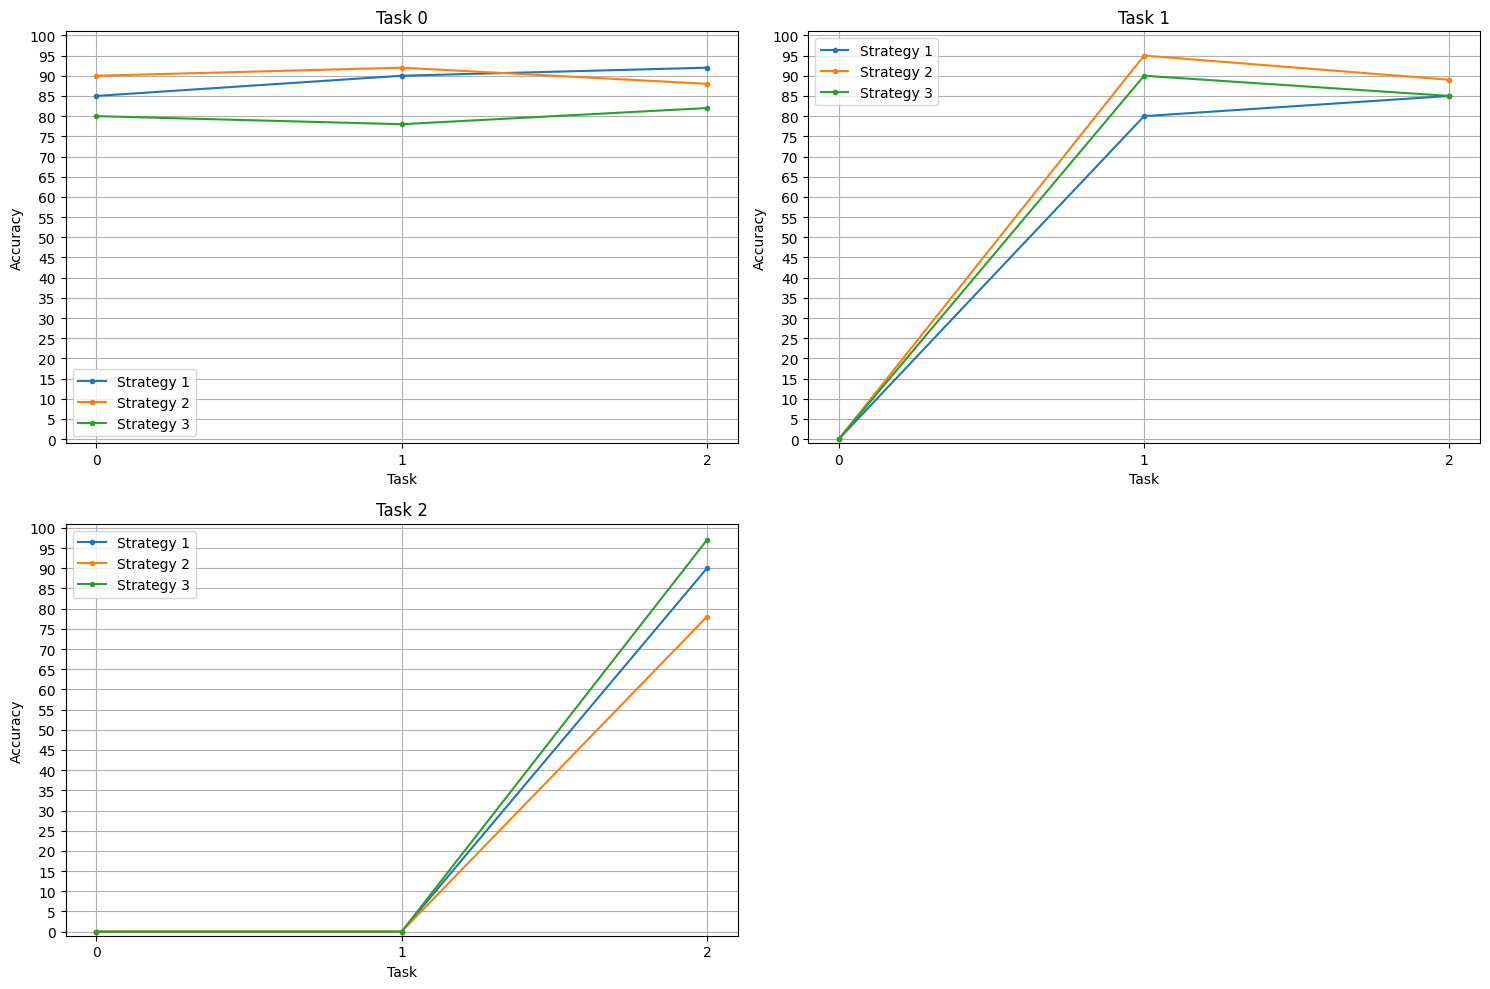

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_task_accuracy(task_acc, fig=None, label=None):
    """
    Plot the accuracy of each individual task.

    Args:
        task_acc (dict): A dictionary containing the accuracy of each task.
        fig (matplotlib.figure.Figure, optional): The figure to use for plotting.
            If not provided, a new figure will be created.

    Returns:
        matplotlib.figure.Figure: The updated figure containing the plots.
    """
    if fig is None:
        num_tasks = len(task_acc)
        num_rows = (num_tasks + 1) // 2  # Number of rows in the subplots grid
        fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
        axes = axes.flatten()
        plot_num = 0
    else:
        axes = fig.get_axes()
        plot_num = 0


    for idx, (key, ax) in enumerate(zip(task_acc.keys(), axes[plot_num:])):
        ax.plot(task_acc[key], label=label, marker='.')
        ax.grid(True)
        ax.set_xlabel('Task')
        ax.set_ylabel('Accuracy')
        ax.set_yticks(np.arange(0, 101, 5))
        ax.set_ylim(-1, 101)  # Set y-axis limits
        ax.set_title(f"Task {key}", loc='center')
        ax.set_xticks(list(task_acc.keys()))
        ax.legend()
        plot_num += 1

    # Remove any unused subplots if num_tasks is odd
    for i in range(plot_num, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    return fig

# Example usage:
strategy_dict = {
    "Strategy 1": {
        0: [85, 90, 92],
        1: [0, 80, 85],
        2: [0, 0, 90],
        # Add more tasks as needed...
    },
    "Strategy 2": {
        0: [90, 92, 88],
        1: [0, 95, 89],
        2: [0, 0, 78],
        # Add more tasks as needed...
    },
    "Strategy 3": {
        0: [80, 78, 82],
        1: [0, 90, 85],
        2: [0, 0, 97],
        # Add more tasks as needed...
    },
}
fig = None
for key, value in strategy_dict.items():
    print(f"Strategy: {key}, Tasks: {list(value.keys())}")
    print(f"Task Accuracy: {value}")
    fig = plot_individual_task_accuracy(value, fig, label=key)

# Display the final figure with all the plots
plt.show()


Strategy: Strategy 1, Tasks: [0, 1, 2]
Task Accuracy: {0: [85, 90, 92], 1: [0, 80, 85], 2: [0, 0, 90]}
Strategy: Strategy 2, Tasks: [0, 1, 2]
Task Accuracy: {0: [90, 92, 88], 1: [0, 95, 89], 2: [0, 0, 78]}
Strategy: Strategy 3, Tasks: [0, 1, 2]
Task Accuracy: {0: [80, 78, 82], 1: [0, 90, 85], 2: [0, 0, 97]}


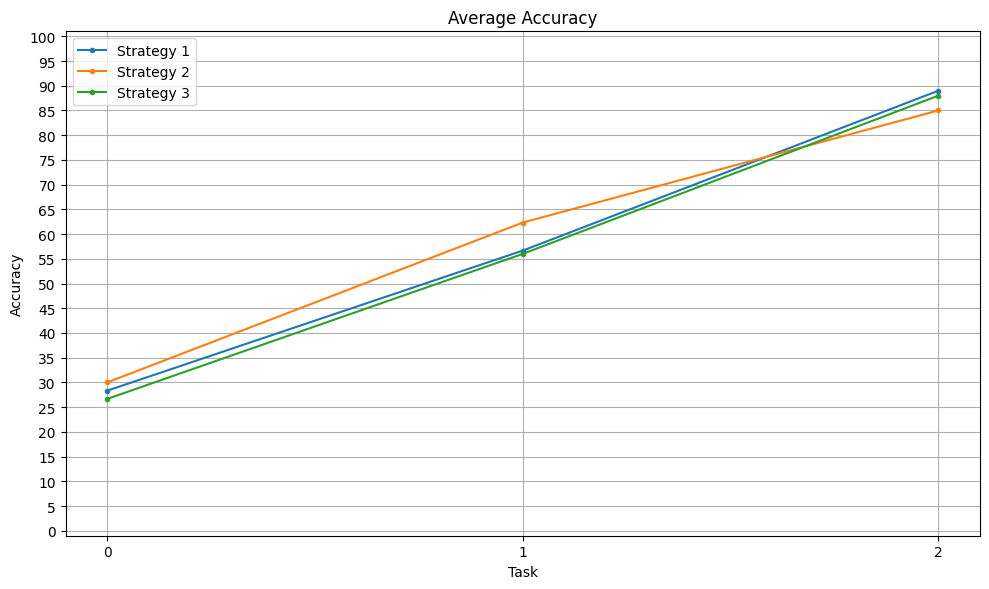

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_accuracy(task_acc, fig=None, label=None):
    """
    Plot the average accuracy of all tasks.

    Args:
        task_acc (dict): A dictionary containing the accuracy of each task.
        fig (matplotlib.figure.Figure, optional): The figure to use for plotting.
            If not provided, a new figure will be created.
        label (str, optional): Label for the current plot. Only used if `fig` is provided.

    Returns:
        matplotlib.figure.Figure: The figure containing the plot.
    """
    if fig is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        ax = fig.get_axes()[0]

    num_tasks = len(task_acc)
    averages = [sum(values) / num_tasks for values in zip(*task_acc.values())]
    ax.plot(averages, marker='.', label=label)
    ax.grid(True)
    ax.set_xlabel('Task')
    ax.set_ylabel('Accuracy')
    ax.set_yticks(np.arange(0, 101, 5))
    ax.set_ylim(-1, 101)
    ax.set_xticks(list(task_acc.keys()))
    ax.set_title('Average Accuracy')
    ax.legend()

    plt.tight_layout()

    return fig

# Example usage:
strategy_dict = {
    "Strategy 1": {
        0: [85, 90, 92],
        1: [0, 80, 85],
        2: [0, 0, 90],
        # Add more tasks as needed...
    },
    "Strategy 2": {
        0: [90, 92, 88],
        1: [0, 95, 89],
        2: [0, 0, 78],
        # Add more tasks as needed...
    },
    "Strategy 3": {
        0: [80, 78, 82],
        1: [0, 90, 85],
        2: [0, 0, 97],
        # Add more tasks as needed...
    },
}
fig = None
for key, value in strategy_dict.items():
    print(f"Strategy: {key}, Tasks: {list(value.keys())}")
    print(f"Task Accuracy: {value}")
    fig = plot_average_accuracy(value, fig, label=key)

# Display the final figure with all the plots
plt.show()

Strategy: Strategy 1, Tasks: [0, 1, 2]
Task Accuracy: {0: [85, 90, 92], 1: [0, 80, 85], 2: [0, 0, 90]}
Strategy: Strategy 2, Tasks: [0, 1, 2]
Task Accuracy: {0: [90, 92, 88], 1: [0, 95, 89], 2: [0, 0, 78]}
Strategy: Strategy 3, Tasks: [0, 1, 2]
Task Accuracy: {0: [80, 78, 82], 1: [0, 90, 85], 2: [0, 0, 97]}


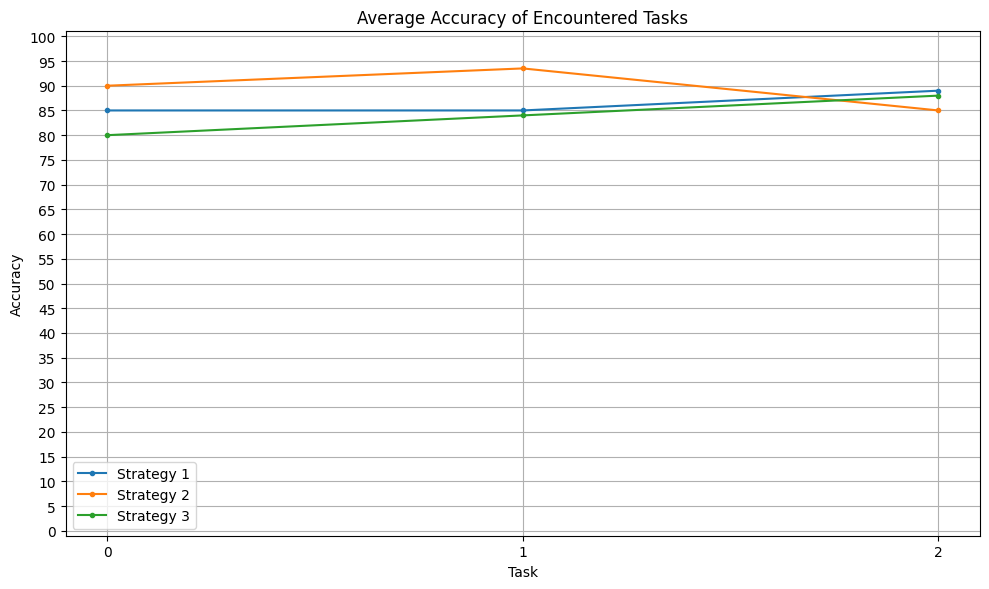

In [2]:
import matplotlib.pyplot as plt
import numpy as np
def plot_encountered_tasks_accuracy(task_acc, fig=None, label=None):
    """
    Plot the average accuracy of only encountered tasks.

    Args:
        task_acc (dict): A dictionary containing the accuracy of each task.
        fig (matplotlib.figure.Figure, optional): The figure to use for plotting.
            If not provided, a new figure will be created.
        label (str, optional): Label for the current plot. Only used if `fig` is provided.

    Returns:
        matplotlib.figure.Figure: The figure containing the plot.
    """
    if fig is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        ax = fig.get_axes()[0]

    encountered_averages = []
    for last_key in range(len(next(iter(task_acc.values())))):
        total_last_element = 0
        num_keys = 0

        for key, value in task_acc.items():
            if int(key) <= int(last_key):
                last_element = value[int(last_key)]
                total_last_element += last_element
                num_keys += 1

        avg = total_last_element / num_keys
        encountered_averages.append(avg)

    ax.plot(encountered_averages, marker='.', label=label)
    ax.grid(True)
    ax.set_xlabel('Task')
    ax.set_ylabel('Accuracy')
    ax.set_yticks(np.arange(0, 101, 5))
    ax.set_ylim(-1, 101)
    ax.set_xticks(list(task_acc.keys()))
    ax.set_title('Average Accuracy of Encountered Tasks')
    ax.legend()

    plt.tight_layout()

    return fig

# Example usage:
strategy_dict = {
    "Strategy 1": {
        0: [85, 90, 92],
        1: [0, 80, 85],
        2: [0, 0, 90],
        # Add more tasks as needed...
    },
    "Strategy 2": {
        0: [90, 92, 88],
        1: [0, 95, 89],
        2: [0, 0, 78],
        # Add more tasks as needed...
    },
    "Strategy 3": {
        0: [80, 78, 82],
        1: [0, 90, 85],
        2: [0, 0, 97],
        # Add more tasks as needed...
    },
}
fig = None
for key, value in strategy_dict.items():
    print(f"Strategy: {key}, Tasks: {list(value.keys())}")
    print(f"Task Accuracy: {value}")
    fig = plot_encountered_tasks_accuracy(value, fig, label=key)

# Display the final figure with all the plots
plt.show()